# Analysis of jitters and shimmers in Speech
* motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,
* Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/Users/hanliyang/Documents/GitHub/Parkinson-Prediagnosis')

In [11]:
df_jitterShimmer = pd.read_csv("NLP/Data/jitters/jitter_feature.csv")
columns = df_jitterShimmer.columns[4:-3].values
df_jitterShimmer = df_jitterShimmer[columns]
df_jitterShimmer


,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR
0,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640
1,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183
2,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047
3,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445
4,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,22.485,33.485,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369
5871,21.988,32.988,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886
5872,21.495,32.495,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065
5873,21.007,32.007,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422


## Running the torch nn regression model on the UCLA ds

In [63]:
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import torch
import tqdm

from sklearn.model_selection import train_test_split

X_columns = df_jitterShimmer.columns[2:].values
X = df_jitterShimmer[X_columns]
y_columns = df_jitterShimmer.columns[0:2].values
y = df_jitterShimmer[y_columns]

X_train, X_test, y_train, y_test = train_test_split(X,y.iloc[:,0],test_size=0.1, random_state=42)
 
model = nn.Sequential(
    nn.Linear(13, 256),
    nn.ReLU(),

    nn.Dropout(0.2),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 16),
    nn.ReLU(),

    nn.Linear(16, 1) # Have to change with input amount
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)


X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32) # X_test
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1) # Have to change with input amount

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
 
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            end = min(start + batch_size, len(X_train))
            # take a batch
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    #print(y_test, y_pred)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

MSE: 59.82
RMSE: 7.73


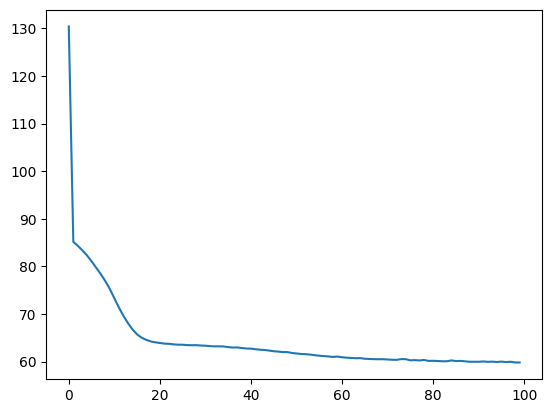

In [64]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [65]:
model.eval()
y_pred = model(X_test)
y_pred = y_pred.detach().numpy()

df = pd.DataFrame(y_pred, columns=["motor_UPDRS"])
df1 = pd.DataFrame(y_test, columns=["motor_UPDRS"]) 

df_all = pd.concat([df, df1], axis = 1)

pd.set_option('display.max_rows', 100)
df_all

,motor_UPDRS,motor_UPDRS
0,22.673704,33.084000
1,20.358656,7.159900
2,23.059233,11.218000
3,22.743708,12.759000
4,22.399075,25.391001
...,...,...
583,19.931810,21.747000
584,19.328550,9.090400
585,19.847227,21.107000
586,23.354227,11.663000


## Detecting Jitter and Shimmer

In [67]:
import glob
import numpy as np
import pandas as pd
import parselmouth 
import statistics


from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    duration = call(sound, "Get total duration") # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    return duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

* SEPERATE NOTEBOOK